# Resolution analysis

We exemplify how to compute resolution kernels and the formal resolution matrix for a 2D ERT inversion. For the theory, we refer to the PhD thesis of Günther (2004), chapter 2.5 and examples in chapter 4.

In [1]:
from math import sqrt, pi
import numpy as np
import pygimli as pg
from pygimli.physics import ert
from pygimli.solver.leastsquares import lsqr, cgls

First, we load the gallery example and do a standard error estimation.

In [2]:
data = pg.getExampleData("ert/gallery.dat")
data.estimateError(0.02)

24/07/24 - 08:19:58 - pyGIMLi - INFO - Looking for ert/gallery.dat in gimli-org/example-data/
24/07/24 - 08:19:58 - pyGIMLi - INFO - Cache c:\Guenther.T\src\gimli\gimli\pygimli\physics\ert\ert.py:createGeometricFactors restored (0.0s x 23): C:\Guenther.T\Anwendungsdaten\pygimli\Cache\13633420947223655174


24/07/24 - 08:19:59 - pyGIMLi - INFO - Found 2 regions.
24/07/24 - 08:19:59 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
24/07/24 - 08:19:59 - pyGIMLi - INFO - Found 2 regions.
24/07/24 - 08:19:59 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
24/07/24 - 08:19:59 - pyGIMLi - INFO - Creating forward mesh from region infos.
24/07/24 - 08:19:59 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


24/07/24 - 08:19:59 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 1913 Cells: 3640 Boundaries: 2822
24/07/24 - 08:19:59 - pyGIMLi - INFO - Use median(data values)=204.445
24/07/24 - 08:19:59 - pyGIMLi - INFO - Created startmodel from forward operator: 511, min/max=204.445000/204.445000
24/07/24 - 08:19:59 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000002C129C07130>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000002C129C071D0>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x000002C129C07220>
min/max (data): 84.65/367
min/max (error): 2%/2%
min/max (start model): 204/204
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  304.39
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   15.75 (dPhi = 94.31%) lam: 15.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    1.05 (dPhi = 82.95%) lam: 15.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    1.08 (dPhi = 0.35%) lam: 15.0
################################################################################
#                Abort criterion reached: dPhi = 0.35 (< 2.0%)             

(<Axes: xlabel='$x$ in m', ylabel='Depth in m'>,
 <matplotlib.colorbar.Colorbar at 0x2c1319cf910>)

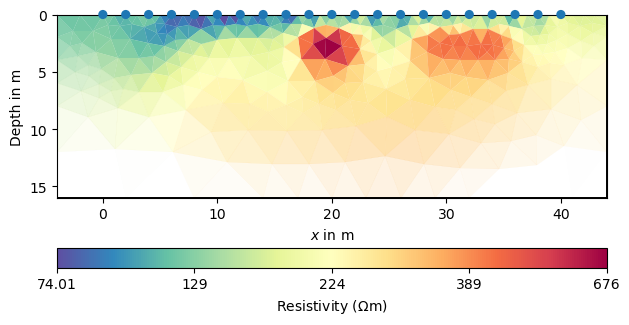

In [3]:
mgr = ert.Manager(data)
model = mgr.invert(lam=15, quality=34.4, verbose=True)
mgr.showResult()

In [4]:
# We save a few things for easier use as they might not come
# from a manager but an inversion instance.
inv = mgr.inv # inversion (no inv no resolution)
fop = mgr.fop # forward operator
mesh = mgr.paraDomain  # the inversion mesh
J = fop.jacobian()  # could also be load from disk
td = inv.dataTrans  # data transformation (e.g. lin/log/symlog)
tm = inv.modelTrans  # model transformation (typically log or logLU)
C = fop.constraints()  # (sparse) regularization matrix

In [5]:
# The Jacobian is the error-scaled sensitivity matrix,
# taking the transformation derivatives into account.
left = td.deriv(inv.response) / inv.errorVals
right = 1 / tm.deriv(model)
DS = pg.matrix.MultLeftRightMatrix(J, left, right)

This function is (also taking data transformation into account) available through `pygimli.frameworks.scaledJacobianMatrix(inv)`.

Let us retrieve one row of the Jacobian matrix (works for all types) by multiplying with a zero data vector containing one element with 1.
The number corresponds to the data index, result is the scaled Jacobian.

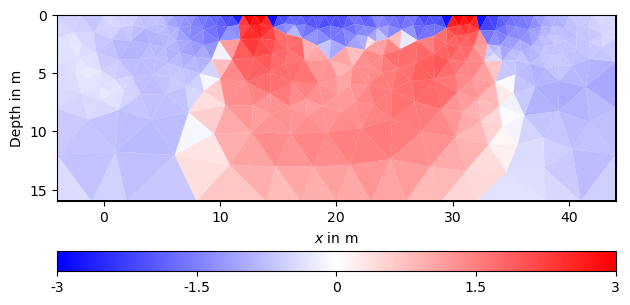

In [6]:
one = pg.Vector(len(inv.dataVals))
one[111] = 1
Jrow = DS.transMult(one)
pg.show(mesh, pg.math.symlog(Jrow, 1e-2), cMin=-3, cMax=3, cMap="bwr");

We now do the opposite and extract a row for a specific cell by searching the closest midpoint to a given position.
It states how much this cell is covered by the individual data.

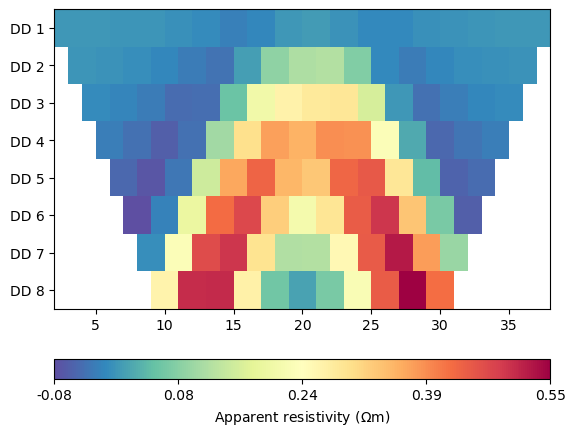

In [7]:
pos = [19.5, -4, 0]
d2 = np.sum((mesh.cellCenters().array() - pos)**2, axis=1)
nr = int(np.argmin(d2)) # closest point
one = pg.Vector(len(model))
one[nr] = 1
Jrow = DS.mult(one)
data.show(Jrow);

We construct a block matrix with the Jacobian matrix above and the regularization matrix below, scaled by the square root of the regularization parameter.

In [8]:
# Now we construct a block matrix of jacobian and regularization
# below each other.
JC = pg.BlockMatrix()
JC.addMatrix(DS, 0, 0)
JC.addMatrix(C, DS.rows(), 0, sqrt(inv.lam))
JC.recalcMatrixSize()
print(J.rows(), C.rows(), JC.rows(), JC.cols())

116 731 847 511


We put this into the inverse solver (eq. 2.50 in Günther, 2004) and compute the corresponding resolution kernel.

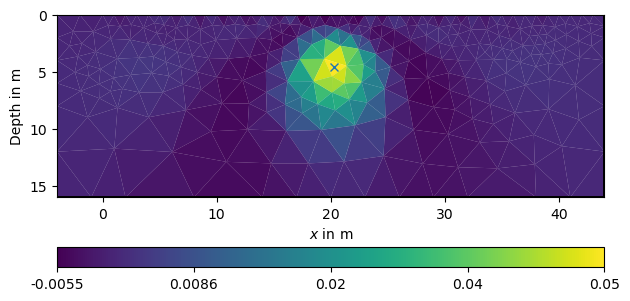

In [9]:
invec = pg.cat(Jrow, pg.Vector(C.rows()))
reskernel = lsqr(JC, invec) # , maxiter=50)
ax, cb = pg.show(mesh, reskernel)
ax.plot(mesh.cell(nr).center().x(), mesh.cell(nr).center().y(), "x");

This is all implemented in the function `modelResolutionKernel`.

(<Axes: xlabel='$x$ in m', ylabel='Depth in m'>,
 <matplotlib.colorbar.Colorbar at 0x2c1333597c0>)

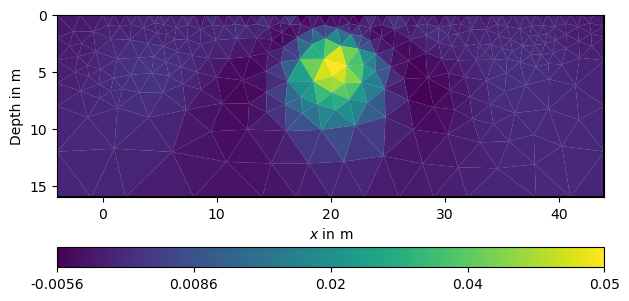

In [10]:
from pygimli.frameworks.resolution import modelResolutionKernel
pg.show(mesh, modelResolutionKernel(inv, nr))

The resolution radius is the radius of the equivalent circle assuming a constant resolution kernel, i.e. circle_area*RM[i,i]=cell_size.
Note that for 3D eq. (2.46a) needs to be used.

In [11]:
resrad = (mesh.cell(nr).size()/reskernel[nr]/pi)**0.5
print(resrad)
# pg.plt.Circle((mesh.cell(nr).center().x(), mesh.cell(nr).center().y()),
#               resrad, color="magenta")

2.8377405368424653


As the problem is small, we can compute the whole matrix.
We convert them to numpy.array and do the same scaling by broadcasting, i.e. using a column vector for left and a row vector for right hand side.

In [12]:
JJ = np.reshape(left, [-1, 1]) * pg.utils.gmat2numpy(J) * \
    np.reshape(right, [1, -1])
cw = np.reshape(inv.fop.regionManager().constraintWeights() ,[-1, 1])
CC =  cw * pg.utils.sparseMat2Numpy.sparseMatrix2Dense(C)

Now we compute the formal resolution matrix (2.42) and extract the same kernel to show it is 

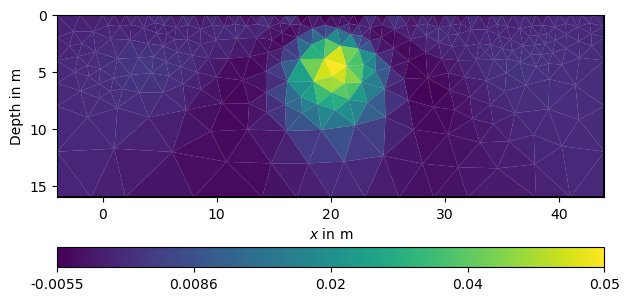

In [13]:
JTJ = JJ.T.dot(JJ)
JI = np.linalg.inv(JTJ+CC.T.dot(CC)*inv.lam)
RM = JI.dot(JTJ)
ax, cb = pg.show(mesh, RM[:, nr])

Taking the diagonals of the resolution matrices, we can compute a resolution radius for every model cell and display it.

(<Axes: xlabel='$x$ in m', ylabel='Depth in m'>,
 <matplotlib.colorbar.Colorbar at 0x2c133425df0>)

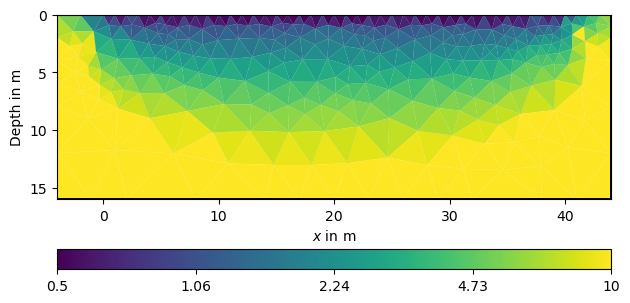

In [14]:
rm = np.diag(RM)
resolutionRadVec = np.abs(mesh.cellSizes()/rm/pi)**0.5
pg.show(mesh, resolutionRadVec, cMin=0.5, cMax=10, logScale=True)

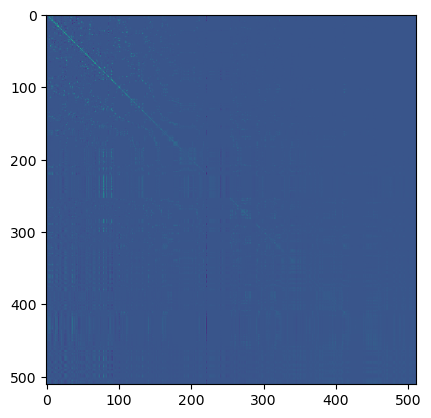

In [15]:
from pygimli.frameworks.resolution import modelResolutionMatrix
RM = modelResolutionMatrix(inv)
pg.plt.imshow(RM)

### Data resolution matrix
Similarly, we compute the data resolution (also known as information density) matrix according to eq. (2.43). It defines the information contribution and cross-dependency of the individual measurements.

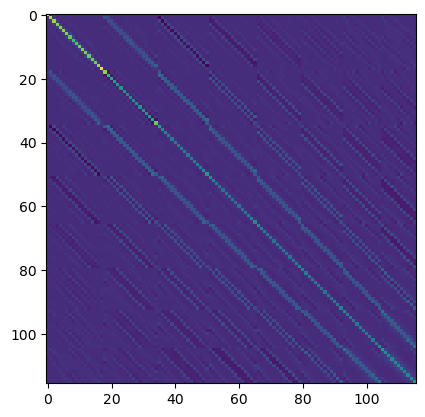

In [16]:
RD = JJ @ JI @ JJ.T
pg.plt.imshow(RD)

The matrix describes the interdependency of the data with each other. The main diagonal of the RD matrix contains the information content contributed by the individual data points, i.e. the contribution and independency of the data. It can be plotted as pseudosection.

(<Axes: >, <matplotlib.colorbar.Colorbar at 0x2c131d93850>)

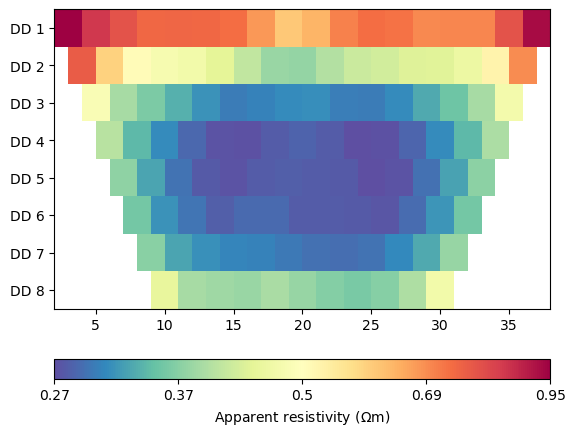

In [17]:
rd = np.diag(RD)
data.show(rd)

The smallest dipole separations show the highest values, but it decreases with increasing dipole distance, before it eventually increases again for the largest separation. It also increases to the sides, showing that the outermost measurements are very important as they cannot be easilyl covered by others like it is the case for the central data.

We extract a single column from the matrix to show the interdependency in more detail.

(<Axes: >, <matplotlib.colorbar.Colorbar at 0x2c13b6c6460>)

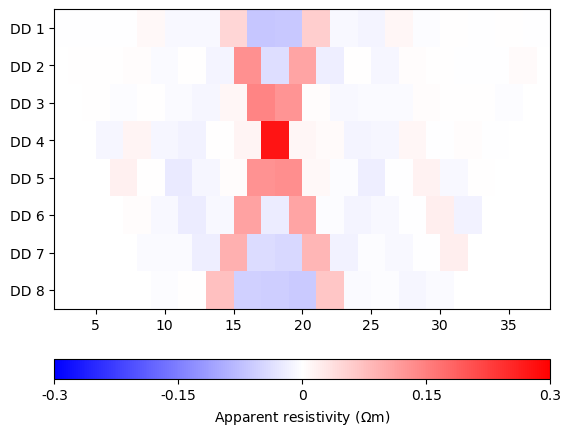

In [18]:
data.show(RD[:, 57], cMin=-.3, cMax=.3, cMap="bwr")

Plotting an individual column of RD shows that the measurements are correlated with those using the same current or potential dipole, but also with all other data using any of the electrodes.

In [19]:
from pygimli.frameworks.resolution import resolutionMatrix
RM, RD = resolutionMatrix(inv, True)

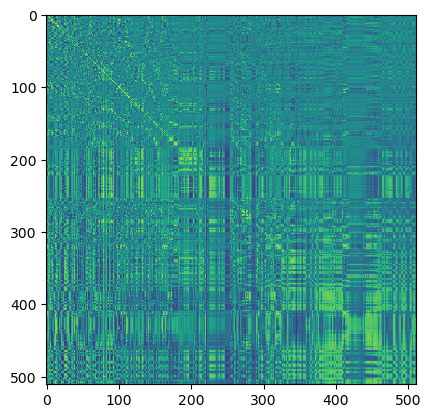

In [20]:
pg.plt.imshow(pg.math.symlog(RM, 1e-4))

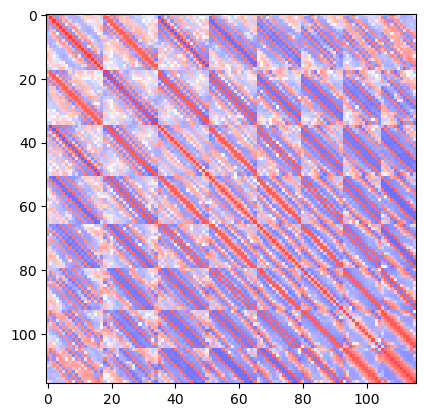

In [21]:
pg.plt.imshow(pg.math.symlog(RD, 1e-4), cmap="bwr", vmin=-5, vmax=5)